## <div align='center'>Bitcoin Sentiment Analysis</div>
----
### <div align='center'>By Patrick Barrett, Matt Rentner, Irina Gasnikova and Jemima Chellaswamy</div>

Cryptocurrency price for the past couple of years is very tumultuous and they are widely used for retail purchases or trading but has gained lot of investors interest in the recent years. Investors are seeking insights on digital currency data for intelligently predicting and investing. Recently sentiment analysis using digital currency data collected from social media to observe the sentiments effect on the digital currency price has gained lot of popularity. 

In this data analysis we will use the compound polarity score of the sentiments from the tweets, news and bots dataset from kaggle and analyze its effects on bitcoin price. We will also see how the volume of tweets relate to the bitcoin price.

### Import dependencies
----


In [261]:
# Dependencies
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import numpy as np
import pandas as pd
import scipy.stats as stats
import datetime

# set options
pd.options.display.float_format = '{:20,.2f}'.format




### Load and clean bitcoin sentiment analysis dataset obtained from Kaggle

_________________


In [195]:
# Load in csv and clean up data

bitcoin_tweets_df = pd.read_csv("./Resources/df_Final.csv", sep=';|,', engine='python')
# Show the data frame shape
print (f" Rows and columns before clean up: {bitcoin_tweets_df.shape}")
# last two columns are bad - Comma used as seperator - Drop it
bitcoin_tweets_df.drop(bitcoin_tweets_df.columns[[16,17]], axis=1, inplace=True)
#Show the data frame shape to confirm dropping the last 2 columns
print (f" Rows and columns after dropping the last two columns with nulls: {bitcoin_tweets_df.shape}")

bitcoin_tweets_df.dropna(axis='rows', how='all')
print (f" Rows and columns after dropping rows with nulls: {bitcoin_tweets_df.shape}")

# split date and time to its own columns

#rename Date field to date_time
bitcoin_tweets_df.rename(columns = {'Date':'Date_Time'}, inplace = True)

# convert to datetime
pd.to_datetime(bitcoin_tweets_df.Date_Time)

# Split date and time
dates, times = zip(*[(d.date().strftime('%m/%d/%y'), d.time()) for d in pd.to_datetime(bitcoin_tweets_df.Date_Time)])

# Add date and time as seperate columns
bitcoin_tweets_df.insert(0, 'Date', dates)
bitcoin_tweets_df.insert(1, 'Time', times)

# inspect shape
print (f" Rows and columns after splitting date and time: {bitcoin_tweets_df.shape}")

# drop date_time field
bitcoin_tweets_df.drop(bitcoin_tweets_df.columns[[2]], axis = 1, inplace=True)

# inspect shape
print (f" Rows and columns after dropping the date_time column: {bitcoin_tweets_df.shape}")

#display frame
bitcoin_tweets_df = bitcoin_tweets_df.sort_values(by=['Date', 'Time'], ascending=True)
bitcoin_tweets_df.head(5)

 Rows and columns before clean up: (12936, 18)
 Rows and columns after dropping the last two columns with nulls: (12936, 16)
 Rows and columns after dropping rows with nulls: (12936, 16)
 Rows and columns after splitting date and time: (12936, 18)
 Rows and columns after dropping the date_time column: (12936, 17)


,Date,Time,Compound_Score,Total Volume of Tweets,Count_Negatives,Count_Positives,Count_Neutrals,Sent_Negatives,Sent_Positives,Count_News,Count_Bots,Open,High,Low,Close,Volume (BTC),Volume (Currency)
3672,01/01/18,00:00:00,0.13,"3,209.00",497.00,"1,069.00","1,259.00",-0.37,0.50,"2,066.00",384.00,"13,850.49","13,857.01","13,598.91","13,642.93","9,397.41","29,500,000,000,000,000.00"
3673,01/01/18,01:00:00,0.13,"1,263.00",184.00,399.00,462.00,-0.40,0.51,731.00,218.00,"13,642.93","13,690.14","13,330.07","13,352.04","10,781.25","29,100,000,000,000,000.00"
3674,01/01/18,02:00:00,0.12,"1,206.00",217.00,411.00,402.00,-0.40,0.52,747.00,176.00,"13,352.04","13,488.90","13,318.52","13,408.70","8,814.94","2,860,000,000,000,000.00"
3675,01/01/18,03:00:00,0.12,"1,174.00",198.00,376.00,431.00,-0.39,0.52,727.00,169.00,"13,408.70","13,647.63","13,383.99","13,458.77","8,425.70","28,000,000,000,000,000.00"
3676,01/01/18,04:00:00,0.12,"1,296.00",176.00,413.00,488.00,-0.44,0.50,775.00,219.00,"13,458.77","13,633.43","13,364.42","13,631.46","73,197,147.00","27,700,000,000,000,000.00"


### Group hourly bitcoin price, volume and sentiment data by date to get daily bitcoin volume, number of sentiments in a day and the closing price

_____________________

In [198]:
bitcoin_data_groupby_day = bitcoin_tweets_df.groupby(["Date"])

idx = bitcoin_data_groupby_day["Time"].transform(max) == bitcoin_tweets_df['Time']

bitcoin_closing_price = bitcoin_tweets_df[idx].set_index("Date")

bitcoin_daily_df = pd.DataFrame({
    "compound score (avg)": bitcoin_data_groupby_day["Compound_Score"].mean(),
    "# Tweets (-ve)": bitcoin_data_groupby_day["Count_Negatives"].sum(),
    "Sentiment (-ve)": bitcoin_data_groupby_day["Sent_Negatives"].mean(),
    "# Tweets (+ve)": bitcoin_data_groupby_day["Count_Positives"].sum(),
    "Sentiment (+ve Avg)": bitcoin_data_groupby_day["Sent_Positives"].mean(),
    "# Tweets (O)": bitcoin_data_groupby_day["Count_Neutrals"].sum(),
    "Volume BTC":   bitcoin_data_groupby_day["Volume (BTC)"].sum(),
})

bitcoin_daily_df["Closing Price $"] = bitcoin_closing_price["Close"]

bitcoin_daily_df = bitcoin_daily_df.sort_values(by=['Date'], ascending=True, key=pd.to_datetime)

bitcoin_daily_df

,compound score (avg),# Tweets (-ve),Sentiment (-ve),# Tweets (+ve),Sentiment (+ve Avg),# Tweets (O),Volume BTC,Closing Price $
Date,,,,,,,,
08/01/17,0.05,"4,701.00",-0.41,"6,471.00",0.44,"12,089.00","12,525.07","2,731.00"
08/02/17,0.06,"2,732.00",-0.37,"4,734.00",0.42,"9,063.00","8,160.55","2,703.51"
08/03/17,0.06,"3,233.00",-0.39,"5,351.00",0.44,"9,806.00","7,963.73","2,793.37"
08/04/17,0.06,"2,703.00",-0.41,"4,150.00",0.45,"7,959.00","7,635.82","2,855.00"
08/05/17,0.09,"2,115.00",-0.41,"6,258.00",0.40,"8,731.00","16,996.26","3,263.62"
...,...,...,...,...,...,...,...,...
01/17/19,0.12,"3,648.00",-0.41,"7,202.00",0.49,"7,294.00","329,545,381.18","3,682.51"
01/18/19,0.11,"3,557.00",-0.41,"6,999.00",0.49,"7,631.00","423,726,893.63","3,647.29"
01/19/19,0.14,"2,634.00",-0.40,"6,474.00",0.50,"5,650.00","654,819,496.92","3,732.40"


### Distribution of Positive Vs Negative Vs Neutral Tweets About BTC
____

2019-01-21 00:00:00
2017-08-01 00:00:00
                     index  compound score (avg)       # Tweets (-ve)  \
count               539.00                539.00               539.00   
mean                269.00                  0.10             5,301.32   
std                 155.74                  0.03             3,378.67   
min                   0.00                 -0.01                 3.00   
25%                 134.50                  0.08             3,383.50   
50%                 269.00                  0.10             4,376.00   
75%                 403.50                  0.12             6,301.00   
max                 538.00                  0.20            32,143.00   

           Sentiment (-ve)       # Tweets (+ve)  Sentiment (+ve Avg)  \
count               539.00               539.00               539.00   
mean                 -0.41            10,332.19                 0.47   
std                   0.02             5,273.49                 0.03   
min           

,count
sentiment,
Positive,"5,569,049.00"
Negative,"2,857,409.00"
Neutral,"6,543,282.00"


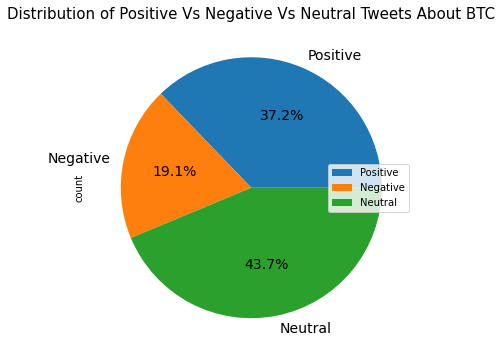

In [245]:
bitcoin_daily_df.reset_index(inplace = True)
print(pd.to_datetime(bitcoin_daily_df["Date"]).max())
print(pd.to_datetime(bitcoin_daily_df["Date"]).min())
print(bitcoin_daily_df.describe())

tweet_distribution_df = pd.DataFrame({})
tweet_distribution_df["sentiment"] = ["Positive", "Negative", "Neutral"]
tweet_distribution_df["count"] = [
    bitcoin_daily_df['# Tweets (+ve)'].sum(),
    bitcoin_daily_df['# Tweets (-ve)'].sum(), 
    bitcoin_daily_df['# Tweets (O)'].sum()
]
tweet_distribution_df.reset_index()
tweet_distribution_df.set_index("sentiment", inplace = True)
axis = tweet_distribution_df.plot.pie(y="count", x = "sentiment", figsize=(10,6), fontsize=14, autopct='%1.1f%%')
axis.set_title("Distribution of Positive Vs Negative Vs Neutral Tweets About BTC", fontsize=15)
axis.legend(loc='center right')
tweet_distribution_df

### Bitcoin Trading Volume Over Time Between Aug, 2017 And Jan, 2019
____

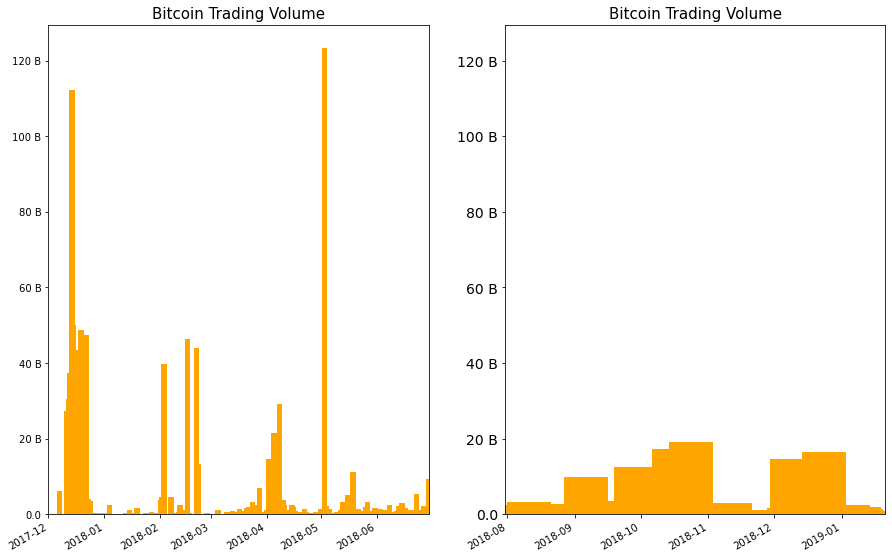

In [291]:
def y_fmt(tick_val, pos):
    if tick_val > 1000000000:
        val = int(tick_val)/1000000000
        return '{:.0f} B'.format(val)
    elif tick_val > 1000000:
        val = int(tick_val)/1000000
        return '{:.0f} M'.format(val)
    elif tick_val > 1000:
        val = int(tick_val) / 1000
        return '{:.0f} k'.format(val)
    else:
        return tick_val

chart, (axis, axis2) = plt.subplots(1,2, figsize=(15,10))
axis.bar(pd.to_datetime(bitcoin_daily_df["Date"]), bitcoin_daily_df["Volume BTC"], color='orange',  width=3.0)
axis2.bar(pd.to_datetime(bitcoin_daily_df["Date"]), bitcoin_daily_df["Volume BTC"], color='orange',  width=20.0)
axis.set_title("Bitcoin Trading Volume", fontsize=15)
axis2.set_title("Bitcoin Trading Volume", fontsize=15)

# positive_tweet_axis = axis.twinx()
# positive_tweet_axis.bar(pd.to_datetime(bitcoin_daily_df["Date"]), bitcoin_daily_df["# Tweets (+ve)"], color='green',  width=3.0)

# axis.set_ylabel("Total TimePoints", fontsize=15);
# axis.set_xlabel("Drug Regimens", fontsize=14);
# axis.legend(loc='upper center')

#plt.xticks(fontsize=14)
axis.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
axis2.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
chart.autofmt_xdate()
axis.set_xlim([datetime.date(2017, 12, 1), datetime.date(2018, 6, 30)])
axis2.set_xlim([datetime.date(2018, 7, 31), datetime.date(2019, 1, 21)])

plt.yticks(fontsize=14)

plt.show()

### Quartiles And Outliers For Positive And Negative Tweets
____

In [298]:
positive_tweet_quartiles = bitcoin_daily_df["# Tweets (+ve)"].quantile([.25, .5, .75])
negative_tweet_quartiles = bitcoin_daily_df["# Tweets (-ve)"].quantile([.25, .5, .75])

pQ1 = positive_tweet_quartiles[0.25]
pQ3 = positive_tweet_quartiles[0.75]
pIQR = pQ3 - pQ1

nQ1 = negative_tweet_quartiles[0.25]
nQ3 = negative_tweet_quartiles[0.75]
nIQR = nQ3 - nQ1

print("\n Upper Quartile, Lower Quartile & Inter Quartile Range")
print("--------------------------------------------------------------\n")

print("Positive Tweets")
print("----------------\n")
print(f"The lower quartile of +ve Tweets is: {pQ1}")
print(f"The upper quartile of +ve Tweets is: {pQ3}")
print(f"The interquartile quartile of +ve Tweets is: {pIQR}")
print(f"The median of +ve Tweets is: {positive_tweet_quartiles[0.5]} ")

print("\n\n Negative Tweets")
print("----------------\n")
print(f"The lower quartile of -ve Tweets is: {nQ1}")
print(f"The upper quartile of -ve Tweets is: {nQ3}")
print(f"The interquartile quartile of -ve Tweets is: {nIQR}")
print(f"The median of -ve Tweets is: {negative_tweet_quartiles[0.5]} ")

print("\n--------------------------------------------------------------\n")

# Determine outliers using upper and lower bounds

plower_range = pQ1 - (1.5 * pIQR)
pupper_range = pQ3 + (1.5 * pIQR)

nlower_range = nQ1 - (1.5 * nIQR)
nupper_range = nQ3 + (1.5 * nIQR)

print("Positive Tweet Outliers")
print("----------------\n")
print(f"Values below {plower_range} could be positive tweet outliers.")
print(f"Values above {pupper_range} could be positive tweet outliers.")

print("\n\n Negative Tweet Outliers")
print("----------------\n")
print(f"Values below {nlower_range} could be negative tweet outliers.")
print(f"Values above {nupper_range} could be negative tweet outliers.")

print("\n--------------------------------------------------------------\n")



 Upper Quartile, Lower Quartile & Inter Quartile Range
--------------------------------------------------------------

Positive Tweets
----------------

The lower quartile of +ve Tweets is: 7421.5
The upper quartile of +ve Tweets is: 11773.0
The interquartile quartile of +ve Tweets is: 4351.5
The median of +ve Tweets is: 8965.0 


 Negative Tweets
----------------

The lower quartile of -ve Tweets is: 3383.5
The upper quartile of -ve Tweets is: 6301.0
The interquartile quartile of -ve Tweets is: 2917.5
The median of -ve Tweets is: 4376.0 

--------------------------------------------------------------

Positive Tweet Outliers
----------------

Values below 894.25 could be positive tweet outliers.
Values above 18300.25 could be positive tweet outliers.


 Negative Tweet Outliers
----------------

Values below -992.75 could be negative tweet outliers.
Values above 10677.25 could be negative tweet outliers.

--------------------------------------------------------------



### Boxplots For Positive And Negative Tweets
____

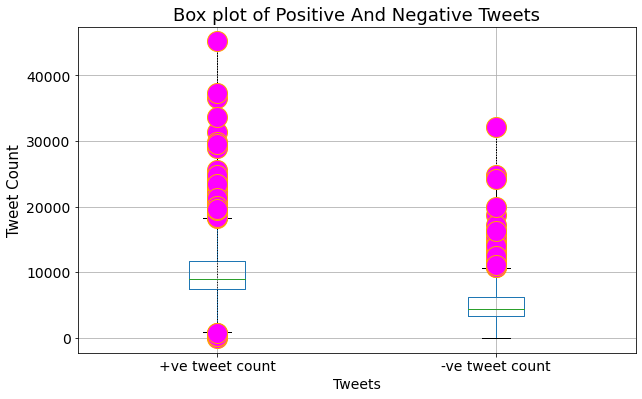

In [301]:
tweet_count_df = pd.DataFrame({
    "+ve tweet count": bitcoin_daily_df["# Tweets (+ve)"],
    "-ve tweet count": bitcoin_daily_df["# Tweets (-ve)"]
})

graph, graph_axes = plt.subplots(figsize=(10,6))
tweet_count_df.boxplot(widths=0.2, ax=graph_axes,
                            flierprops=dict(markerfacecolor="magenta", markersize="20",
                                           markeredgecolor="orange", linestyle="dotted"))
graph_axes.set_title("Box plot of Positive And Negative Tweets", fontsize=18)
graph_axes.set_ylabel("Tweet Count", fontsize=15);
graph_axes.set_xlabel("Tweets", fontsize=14);

graph.suptitle('')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#### Outlier Analysis
____

* From the the above outlier analysis, we do see that there are outliers for both positive & negative tweets that would affect the regression between tweet count against price or volume of BTC. These tweet counts are not measured incorrectly but rather an aggregation of tweets (simply that the tweet count on certain days where very high or low) so the outliers cannot be removed from regression. These tweet count outliers most porbably are strong (low/high) sentiments of people reacting to news about cryptocurrency and cannot be ignored but should rather trigger interest to study or analyze the nature of news itself that triggers a large population to react with strong sentiments and whether it has an effect on price and the volume of BTC transactions 